### Selecting columns, viualizing

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools
import torch
torch.use_deterministic_algorithms(True)

In [2]:
data = pd.read_csv("../dat/data_clean.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273543 entries, 0 to 273542
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tconst                       273543 non-null  object 
 1   titleType                    273543 non-null  object 
 2   primaryTitle                 273543 non-null  object 
 3   originalTitle                273543 non-null  object 
 4   isAdult                      273543 non-null  int64  
 5   startYear                    273543 non-null  object 
 6   endYear                      273543 non-null  object 
 7   runtimeMinutes               273543 non-null  object 
 8   genres                       273543 non-null  object 
 9   averageRating                273543 non-null  float64
 10  numVotes                     273543 non-null  int64  
 11  Budget                       49881 non-null   float64
 12  Gross US & Canada            18982 non-null   float64
 13 

In [4]:
data["Critic reviews"] = data["Critic reviews"].fillna(0)
data["User reviews"] = data["User reviews"].fillna(0)

data["isAdult2"] = data.apply(lambda row: int("Adult" in row["genres"]), axis=1)
print(len(data[data["isAdult"] != data["isAdult2"]]))  # We use the one based on the genres

# tconst was only required for joins
# titleType is only films for us, we filtered them
# we do not use the titles as predictors
# endYear is None for all films
# isAdult will be added back in a consistent format later on

# We drop writers and directors. These are interesting features,
# but having them as binary columns would be infeasible.
data = data.drop(columns=[
    "tconst", "titleType", "primaryTitle", "originalTitle", "endYear",
    "isAdult", "isAdult2", "Gross US & Canada", "Opening weekend US & Canada",
    "writers", "directors"])
data = data.dropna()

318


In [5]:
genre_list = data["genres"].unique().tolist()
for i, entry in enumerate(genre_list):
    genre_list[i] = entry.split(",")

genre_set = set(itertools.chain(*genre_list))
print(genre_set)

{'Mystery', 'Western', 'War', 'Music', 'Crime', 'Musical', 'News', 'Romance', 'Animation', 'Biography', 'Horror', 'Documentary', 'Sport', 'Action', 'Thriller', 'Adventure', 'Comedy', 'Sci-Fi', 'Fantasy', 'Drama', 'Film-Noir', 'Family', 'History'}


In [6]:
# News - History - Biography - Documentary --> Documentary
# Film-Noir - Crime --> Crime
# Western - Action --> Action
genre_set.difference_update(["News", "History", "Biography", "Film-Noir", "Western"])
transformation_dict = {
    "Documentary":  ["News", "History", "Biography", "Documentary"],
    "Crime": ["Film-Noir", "Crime"],
    "Action": ["Western", "Action"]
}
for genre in genre_set:
    print(genre, end=" ")
    if genre not in transformation_dict:
        transformation_dict[genre] = [genre]
    data[f"is{genre}"] = data.apply(lambda row: int(any(g in row["genres"] for g in transformation_dict[genre])), axis=1)

Mystery War Music Crime Musical Romance Animation Horror Documentary Sport Action Thriller Adventure Comedy Sci-Fi Fantasy Drama Family 

In [7]:
results = []
for genre in genre_set:
    results.append(data[f"is{genre}"].sum())

sum_results = sum(results)
for genre in genre_set:
    print(genre, data[f"is{genre}"].sum() / sum_results * 100, "% - ", data[f"is{genre}"].sum())

Mystery 3.4901826744141884 % -  919
War 0.8658995100831719 % -  228
Music 1.7659792639854164 % -  465
Crime 7.569025103490183 % -  1993
Musical 0.5089058524173028 % -  134
Romance 6.737305837226083 % -  1774
Animation 1.993847556112567 % -  525
Horror 4.348486574759789 % -  1145
Documentary 4.564961452280582 % -  1202
Sport 0.9190687782461737 % -  242
Action 9.843910219892901 % -  2592
Thriller 6.63096730090008 % -  1746
Adventure 6.7107212031445815 % -  1767
Comedy 14.488625574417988 % -  3815
Sci-Fi 2.529338042611371 % -  666
Fantasy 2.8179712126390943 % -  742
Drama 21.920929702631877 % -  5772
Family 2.2938741407466483 % -  604


In [8]:
# Genres are added as binary predictors, thus the genres column is no longer used.
data = data.drop(columns=["genres"])  # "isMusical", "isFilm-Noir", "isNews", "isSport", "genres"])

def unrated_to_not_rated(row):
    if row["Rating"] == "Unrated":
        return "Not Rated"
    else:
        return row["Rating"]

data["Rating"] = data.apply(unrated_to_not_rated, axis=1)

In [9]:
data[f"isRated"] = data.apply(lambda row: int(row["Rating"] != "Not Rated"), axis=1)

In [10]:
data = data.drop(columns=["Rating"])

In [11]:
def clean_unknowns(row, column):
    if row[column] == "\\N":
        return None
    else:
        return row[column]

def clean_reviews(row, column):
    if isinstance(row[column], str) and "K" in row[column]:
        if "." in row[column]:
            return int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100
        else:
            return int(row[column][:-1]) * 1000
    else:
        return row[column]

data["startYear"] = data.apply(lambda row: clean_unknowns(row, "startYear"), axis=1)
data["runtimeMinutes"] = data.apply(lambda row: clean_unknowns(row, "runtimeMinutes"), axis=1)
data["User reviews"] = data.apply(lambda row: clean_reviews(row, "User reviews"), axis=1)
data["Critic reviews"] = data.apply(lambda row: clean_reviews(row, "Critic reviews"), axis=1)

for column in ["startYear", "runtimeMinutes", "User reviews", "Critic reviews"]:
    data[column] = pd.to_numeric(data[column])



In [12]:
print("All features present:")
filtered = data.dropna()
print(len(filtered))

All features present:
10714


In [13]:
filtered.corr().style.background_gradient(cmap='coolwarm')

,startYear,runtimeMinutes,averageRating,numVotes,Budget,Gross worldwide,Critic reviews,User reviews,isMystery,isWar,isMusic,isCrime,isMusical,isRomance,isAnimation,isHorror,isDocumentary,isSport,isAction,isThriller,isAdventure,isComedy,isSci-Fi,isFantasy,isDrama,isFamily,isRated
startYear,1.000000,-0.035866,-0.201522,0.000240,-0.023247,-0.057779,0.193535,0.059286,-0.012530,-0.055095,-0.049175,-0.043072,-0.079189,-0.072984,0.061377,0.010315,0.076020,-0.001944,0.062450,0.037106,0.014030,-0.029636,-0.021172,-0.007435,-0.023440,-0.006475,-0.166430
runtimeMinutes,-0.035866,1.000000,0.327356,0.263119,0.281783,0.222601,0.197618,0.263035,-0.004244,0.098452,0.042845,0.034734,0.066672,0.037874,-0.188850,-0.161497,0.132065,0.023717,0.157000,-0.017890,0.023855,-0.198908,0.013944,-0.007126,0.251510,-0.076188,-0.059407
averageRating,-0.201522,0.327356,1.000000,0.373765,0.094344,0.207771,0.320645,0.259345,-0.005072,0.073410,0.039827,0.033494,0.017918,0.017810,0.016830,-0.194478,0.203175,0.030757,-0.088066,-0.086492,-0.027122,-0.116203,-0.039149,-0.050636,0.259717,-0.063889,0.009748
numVotes,0.000240,0.263119,0.373765,1.000000,0.484440,0.604826,0.632424,0.748153,0.026221,-0.003589,-0.039960,0.012083,-0.020421,-0.062362,0.032153,-0.030451,-0.039296,-0.020418,0.143913,0.008170,0.174233,-0.058298,0.161098,0.057248,-0.053881,-0.019788,0.181424
Budget,-0.023247,0.281783,0.094344,0.484440,1.000000,0.618972,0.470934,0.493993,-0.035106,-0.018468,-0.046011,-0.030025,-0.002538,-0.074949,0.156256,-0.114956,-0.066076,-0.014845,0.288313,-0.024849,0.412964,0.001382,0.187617,0.122698,-0.180196,0.073103,0.265037
Gross worldwide,-0.057779,0.222601,0.207771,0.604826,0.618972,1.000000,0.447165,0.528583,-0.029502,-0.022194,-0.024488,-0.057878,-0.004438,-0.046415,0.150514,-0.056392,-0.054449,-0.023446,0.157823,-0.022244,0.302571,0.004148,0.120041,0.085165,-0.143340,0.059786,0.165175
Critic reviews,0.193535,0.197618,0.320645,0.632424,0.470934,0.447165,1.000000,0.635358,0.084005,-0.024894,-0.044073,-0.004029,-0.023878,-0.080864,0.020177,0.107734,-0.017815,-0.043205,0.153225,0.045821,0.174983,-0.093213,0.187049,0.089842,-0.038121,-0.051485,0.252920
User reviews,0.059286,0.263035,0.259345,0.748153,0.493993,0.528583,0.635358,1.000000,0.054678,-0.005661,-0.027985,-0.015094,-0.001391,-0.071699,-0.015183,0.052397,-0.051012,-0.031435,0.168931,0.029438,0.178414,-0.102268,0.187933,0.084869,-0.054181,-0.031068,0.181563
isMystery,-0.012530,-0.004244,-0.005072,0.026221,-0.035106,-0.029502,0.084005,0.054678,1.000000,-0.040548,-0.060337,0.084841,-0.034472,-0.084438,-0.064898,0.224168,-0.100437,-0.046564,-0.113888,0.143020,-0.105588,-0.174180,0.023293,-0.027103,-0.010037,-0.073423,0.018363
isWar,-0.055095,0.098452,0.073410,-0.003589,-0.018468,-0.022194,-0.024894,-0.005661,-0.040548,1.000000,-0.021886,-0.067167,-0.010775,-0.004788,-0.030476,-0.051007,0.058241,-0.018063,-0.021383,-0.054507,-0.044618,-0.079938,-0.035284,-0.037676,0.093656,-0.036042,-0.002274


In [14]:
np.random.seed(42)
test_indices = np.random.choice(len(filtered), replace=False, size=int(len(filtered) / 10))


test_set = filtered.iloc[test_indices]
test_set, test_targets = test_set.drop("averageRating", axis=1).to_numpy(), test_set["averageRating"].to_numpy()
train_set = filtered.iloc[~test_indices]
train_set, train_targets = train_set.drop("averageRating", axis=1).to_numpy(), train_set["averageRating"].to_numpy()

In [15]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10714 entries, 1031 to 273540
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   startYear        10714 non-null  int64  
 1   runtimeMinutes   10714 non-null  float64
 2   averageRating    10714 non-null  float64
 3   numVotes         10714 non-null  int64  
 4   Budget           10714 non-null  float64
 5   Gross worldwide  10714 non-null  float64
 6   Critic reviews   10714 non-null  float64
 7   User reviews     10714 non-null  float64
 8   isMystery        10714 non-null  int64  
 9   isWar            10714 non-null  int64  
 10  isMusic          10714 non-null  int64  
 11  isCrime          10714 non-null  int64  
 12  isMusical        10714 non-null  int64  
 13  isRomance        10714 non-null  int64  
 14  isAnimation      10714 non-null  int64  
 15  isHorror         10714 non-null  int64  
 16  isDocumentary    10714 non-null  int64  
 17  isSport 

### Logistic Regression, MAE

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

test_set = torch.from_numpy(test_set)
test_set_normalized = (test_set - test_set.mean(dim=0, keepdims=True)) / test_set.std(dim=0, keepdims=True)
test_set_normalized = torch.nan_to_num(test_set_normalized, nan=0)
test_targets = torch.from_numpy(test_targets)

train_set = torch.from_numpy(train_set)
train_set_normalized = (train_set - train_set.mean(dim=0, keepdims=True)) / train_set.std(dim=0, keepdims=True)
train_set_normalized = torch.nan_to_num(train_set_normalized, nan=0)
train_targets = torch.from_numpy(train_targets)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x)) * 9 + 1

In [17]:


# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

torch.manual_seed(1337)
model = Model()

opt = torch.optim.SGD(model.parameters(), lr=0.001)

best_loss = np.inf
best_pred_lr = None


epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_pred_lr = pred
            
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.0812], dtype=torch.float64)
Epoch 100, Training Loss (MAE) 1.3073, Validation Loss (MAE) 1.3191

tensor([0.0655], dtype=torch.float64)
Epoch 200, Training Loss (MAE) 1.1067, Validation Loss (MAE) 1.1277

tensor([0.0510], dtype=torch.float64)
Epoch 300, Training Loss (MAE) 0.9485, Validation Loss (MAE) 0.9754

tensor([0.0369], dtype=torch.float64)
Epoch 400, Training Loss (MAE) 0.8289, Validation Loss (MAE) 0.8602

tensor([0.0270], dtype=torch.float64)
Epoch 500, Training Loss (MAE) 0.7429, Validation Loss (MAE) 0.7745

tensor([0.0173], dtype=torch.float64)
Epoch 600, Training Loss (MAE) 0.6819, Validation Loss (MAE) 0.7144

tensor([0.0115], dtype=torch.float64)
Epoch 700, Training Loss (MAE) 0.6455, Validation Loss (MAE) 0.6755

tensor([0.0070], dtype=torch.float64)
Epoch 800, Training Loss (MAE) 0.6217, Validation Loss (MAE) 0.6508

tensor([0.0048], dtype=torch.float64)
Epoch 900, Training Loss (MAE) 0.6062, Validation Loss (MAE) 0.6339

tensor([0.0035], dtype=torch.float64)

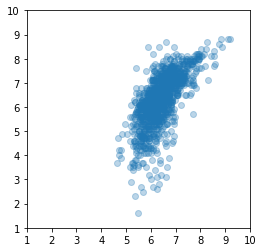

In [18]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Logistic Regression, MSE

In [19]:

loss_fn = nn.MSELoss()
val_loss_fn = nn.L1Loss()
torch.manual_seed(1337)


model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

best_loss = np.inf
epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MSE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.3745], dtype=torch.float64)
Epoch 100, Training Loss (MSE) 1.2241, Validation Loss (MAE) 0.8986

tensor([0.0644], dtype=torch.float64)
Epoch 200, Training Loss (MSE) 0.7631, Validation Loss (MAE) 0.6982

tensor([0.0154], dtype=torch.float64)
Epoch 300, Training Loss (MSE) 0.6741, Validation Loss (MAE) 0.6456

tensor([0.0049], dtype=torch.float64)
Epoch 400, Training Loss (MSE) 0.6500, Validation Loss (MAE) 0.6282

tensor([0.0020], dtype=torch.float64)
Epoch 500, Training Loss (MSE) 0.6414, Validation Loss (MAE) 0.6205

tensor([0.0010], dtype=torch.float64)
Epoch 600, Training Loss (MSE) 0.6377, Validation Loss (MAE) 0.6170

tensor([0.0005], dtype=torch.float64)
Epoch 700, Training Loss (MSE) 0.6357, Validation Loss (MAE) 0.6152

tensor([0.0003], dtype=torch.float64)
Epoch 800, Training Loss (MSE) 0.6347, Validation Loss (MAE) 0.6144

tensor([0.0002], dtype=torch.float64)
Epoch 900, Training Loss (MSE) 0.6341, Validation Loss (MAE) 0.6139

tensor([0.0001], dtype=torch.float64)

### Logistic Regression, BCE

In [20]:

test_targets_bce = (test_targets - 1) / 9
train_targets_bce = (train_targets - 1) / 9

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x))

loss_fn = nn.BCELoss()
val_loss_fn = nn.L1Loss()

best_loss = np.inf

torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets_bce)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (BCE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.0015], dtype=torch.float64)
Epoch 100, Training Loss (BCE) 0.7446, Validation Loss (MAE) 1.5124

tensor([0.0015], dtype=torch.float64)
Epoch 200, Training Loss (BCE) 0.7406, Validation Loss (MAE) 1.4844

tensor([0.0014], dtype=torch.float64)
Epoch 300, Training Loss (BCE) 0.7368, Validation Loss (MAE) 1.4571

tensor([0.0013], dtype=torch.float64)
Epoch 400, Training Loss (BCE) 0.7332, Validation Loss (MAE) 1.4305

tensor([0.0012], dtype=torch.float64)
Epoch 500, Training Loss (BCE) 0.7298, Validation Loss (MAE) 1.4048

tensor([0.0012], dtype=torch.float64)
Epoch 600, Training Loss (BCE) 0.7266, Validation Loss (MAE) 1.3797

tensor([0.0011], dtype=torch.float64)
Epoch 700, Training Loss (BCE) 0.7235, Validation Loss (MAE) 1.3556

tensor([0.0010], dtype=torch.float64)
Epoch 800, Training Loss (BCE) 0.7207, Validation Loss (MAE) 1.3321

tensor([0.0010], dtype=torch.float64)
Epoch 900, Training Loss (BCE) 0.7180, Validation Loss (MAE) 1.3094

tensor([0.0009], dtype=torch.float64)

### ReLU network #2, MAE

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1

model = Model()
list(model.modules())[1:]

[Linear(in_features=26, out_features=32, bias=True),
 Linear(in_features=32, out_features=1, bias=True)]

In [22]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1


loss_fn = nn.L1Loss()
torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])
best_loss = np.inf
# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.7908, Validation Loss (MAE) 0.8410

Epoch 200, Training Loss (MAE) 0.7195, Validation Loss (MAE) 0.7616

Epoch 300, Training Loss (MAE) 0.6796, Validation Loss (MAE) 0.7169

Epoch 400, Training Loss (MAE) 0.6531, Validation Loss (MAE) 0.6893

Epoch 500, Training Loss (MAE) 0.6341, Validation Loss (MAE) 0.6687

Epoch 600, Training Loss (MAE) 0.6197, Validation Loss (MAE) 0.6548

Epoch 700, Training Loss (MAE) 0.6111, Validation Loss (MAE) 0.6468

Epoch 800, Training Loss (MAE) 0.6047, Validation Loss (MAE) 0.6418

Epoch 900, Training Loss (MAE) 0.5990, Validation Loss (MAE) 0.6374

Epoch 1000, Training Loss (MAE) 0.5939, Validation Loss (MAE) 0.6338

Epoch 1100, Training Loss (MAE) 0.5894, Validation Loss (MAE) 0.6312

Epoch 1200, Training Loss (MAE) 0.5851, Validation Loss (MAE) 0.6287

Epoch 1300, Training Loss (MAE) 0.5811, Validation Loss (MAE) 0.6264

Epoch 1400, Training Loss (MAE) 0.5777, Validation Loss (MAE) 0.6245

Epoch 1500, Training Loss (MA

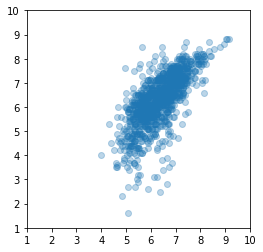

In [23]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### ReLU network #4, MAE

In [24]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_dim = 32
        
        self.layer1 = nn.Linear(26, self.hidden_dim, dtype=torch.double)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer4 = nn.Linear(self.hidden_dim, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
    
        return torch.sigmoid(self.layer4(x)) * 9 + 1


loss_fn = nn.L1Loss()
best_loss = np.inf


torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])

# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8294, Validation Loss (MAE) 0.8535

Epoch 200, Training Loss (MAE) 0.8191, Validation Loss (MAE) 0.8437

Epoch 300, Training Loss (MAE) 0.8126, Validation Loss (MAE) 0.8375

Epoch 400, Training Loss (MAE) 0.8056, Validation Loss (MAE) 0.8305

Epoch 500, Training Loss (MAE) 0.7977, Validation Loss (MAE) 0.8224

Epoch 600, Training Loss (MAE) 0.7878, Validation Loss (MAE) 0.8129

Epoch 700, Training Loss (MAE) 0.7756, Validation Loss (MAE) 0.8011

Epoch 800, Training Loss (MAE) 0.7609, Validation Loss (MAE) 0.7870

Epoch 900, Training Loss (MAE) 0.7432, Validation Loss (MAE) 0.7702

Epoch 1000, Training Loss (MAE) 0.7232, Validation Loss (MAE) 0.7519

Epoch 1100, Training Loss (MAE) 0.7029, Validation Loss (MAE) 0.7328

Epoch 1200, Training Loss (MAE) 0.6826, Validation Loss (MAE) 0.7138

Epoch 1300, Training Loss (MAE) 0.6648, Validation Loss (MAE) 0.6959

Epoch 1400, Training Loss (MAE) 0.6490, Validation Loss (MAE) 0.6801

Epoch 1500, Training Loss (MA

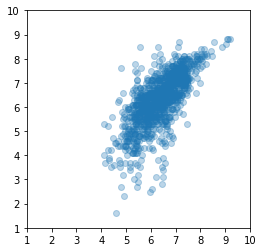

In [25]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

In [26]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_dim = 32
        
        self.layer1 = nn.Linear(26, self.hidden_dim, dtype=torch.double)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer4 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer5 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer6 = nn.Linear(self.hidden_dim, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
    
        return torch.sigmoid(self.layer6(x)) * 9 + 1

loss_fn = nn.L1Loss()
torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-2)

epoch = 0
grad_norm = 1
# norm_factor = sum([w.weight.shape[0] * w.weight.shape[1] + w.bias.shape[0] for w in list(model.modules())[1:]])
pred = None 
best_loss = np.inf


# while grad_norm >= 1e-4:
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        # print(grad_norm)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_pred_relu = pred
            
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1
    
    # grad_norm = sum([torch.norm(w.weight.grad)**2 + torch.norm(w.bias.grad)**2 for w in list(model.modules())[1:]]) / norm_factor

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8288, Validation Loss (MAE) 0.8566

Epoch 200, Training Loss (MAE) 0.8280, Validation Loss (MAE) 0.8559

Epoch 300, Training Loss (MAE) 0.8273, Validation Loss (MAE) 0.8552

Epoch 400, Training Loss (MAE) 0.8264, Validation Loss (MAE) 0.8543

Epoch 500, Training Loss (MAE) 0.8253, Validation Loss (MAE) 0.8533

Epoch 600, Training Loss (MAE) 0.8240, Validation Loss (MAE) 0.8520

Epoch 700, Training Loss (MAE) 0.8219, Validation Loss (MAE) 0.8499

Epoch 800, Training Loss (MAE) 0.8186, Validation Loss (MAE) 0.8467

Epoch 900, Training Loss (MAE) 0.8140, Validation Loss (MAE) 0.8421

Epoch 1000, Training Loss (MAE) 0.8065, Validation Loss (MAE) 0.8344

Epoch 1100, Training Loss (MAE) 0.7922, Validation Loss (MAE) 0.8201

Epoch 1200, Training Loss (MAE) 0.7616, Validation Loss (MAE) 0.7898

Epoch 1300, Training Loss (MAE) 0.7009, Validation Loss (MAE) 0.7281

Epoch 1400, Training Loss (MAE) 0.6349, Validation Loss (MAE) 0.6655

Epoch 1500, Training Loss (MA

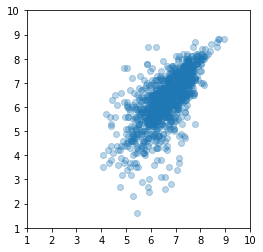

In [27]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Save the data for plot

In [28]:
# some random data
x1 = best_pred_lr.squeeze().numpy()
x2 = best_pred_relu.squeeze().numpy()
y = test_targets.squeeze().numpy()

np.save("../dat/data_fig1/pred_lr.npy", x1)
np.save("../dat/data_fig1/pred_relu.npy", x2)
np.save("../dat/data_fig1/true_ratings.npy", y)